In [2]:
#AIM
#to make a rank plot - LOGIC:
#If era5 is < ensemble spread = colour1
#if era5 is within ensemble spread = white
#if era5 is > ensemble spread colour 2.

#import ensemble spread - data array? (lat, lon, ensemble)
#find max and min of data array (at somepoint might change to 2.5-97.5%?) (lat, lon) for max and min
#worth making a max and min arrays (lat, lon) so no longer dealing with ensembles data structure?


#import era5.


#improved logic
#basically going to find the percentage of where era5 lies in its half of the distribution
#(e.g. 1-3 is the ensemble distribution - era5 is 2.5 then it lies at 50% in the positive half of the distribution)
#If its <-1 then outwith distribution (too small), If >1 then also outwith distribution as too big.
#for each grid point
#(era5 - (min +((max - min)/2)))/((max - min)/2) to get the percentage for its half
#lower half negative
#upper half positive
#means I don;t need to set the bounds/more continuous/can just faff with colour bars - need a diverging one
#zero will be white and two colours either end ond outwith needs to be dark colour - can maybe create end of colour bar at -1 and 1?


In [24]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import os
import xesmf as xe

In [27]:
#folderpath for the ensemble files
folder = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/historical/HadGEM3-GC31-LL/'

ens_files = [os.path.join(folder, filename) for filename in os.listdir(folder) if 'regression_map' in filename]

print(len(ens_files))

#opening each ensemble file and storing in one multi-dim array with new dimension ensemble as well as prev lat, lons.
ds = xr.open_mfdataset(ens_files, concat_dim='ensemble', combine='nested')

#extracting the nao regression data
nao = ds['regression_NAO_djf']

print(nao.dims)
print(nao.shape)

#extracting the max and min from the ensemble spread
nao_max = nao.max(dim='ensemble')
nao_min = nao.min(dim='ensemble')

#now time to import era5
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/era5/era5_DJF_NAO_regression_map_1940-2024.nc')

#This creates a regridder so I can put era5 onto the ensemble grid
regridder = xe.Regridder(era5, nao_max, method='bilinear', periodic=False)
era5_regrid = regridder(era5['regression_NAO_djf'])

spread = (nao_max - nao_min)/2
midpoint = nao_min + spread
anomaly = (era5_regrid - midpoint)/spread

print(anomaly)


56
('ensemble', 'lat', 'lon')
(56, 25, 53)
<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
dask.array<truediv, shape=(25, 53), dtype=float64, chunksize=(25, 53), chunktype=numpy.ndarray>
Coordinates:
    season   <U3 12B 'DJF'
    mode     int64 8B 0
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0


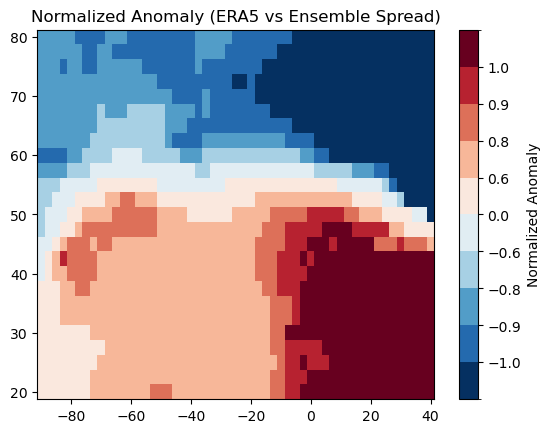

In [34]:
fig, ax = plt.subplots()

#levels = np.arange(-1.25, 1.5, 0.25)
levels = (-1.1,-1,-0.9, -0.8, -0.6, 0, 0.6, 0.8, 0.9, 1, 1.1)
norm = BoundaryNorm(levels, ncolors=256, clip=True)

pcm = ax.pcolormesh(
    anomaly['lon'], anomaly['lat'], anomaly,
    cmap='RdBu_r',
    norm=norm
)

cbar = fig.colorbar(pcm, ax=ax, boundaries=levels, ticks=levels[1:-1])
cbar.set_label('Normalized Anomaly')

ax.set_title('Normalized Anomaly (ERA5 vs Ensemble Spread)')
plt.show()


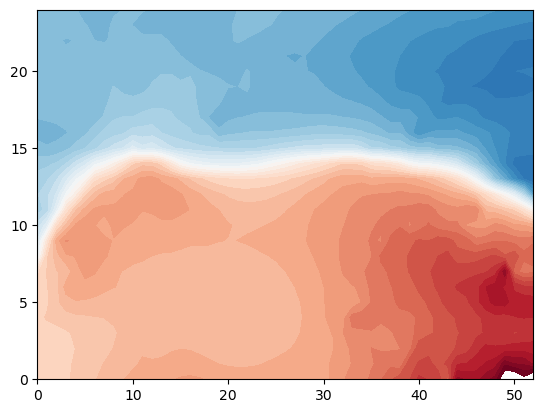

In [14]:
fig, ax = plt.subplots()

levels = np.arange(-2,2.1,0.1)
ax.contourf(anomaly, cmap='RdBu_r', levels=levels)

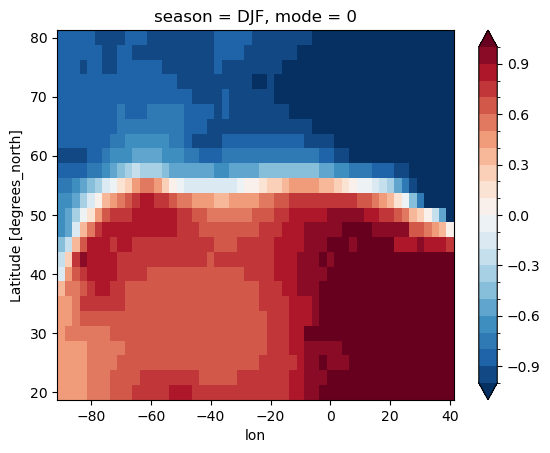

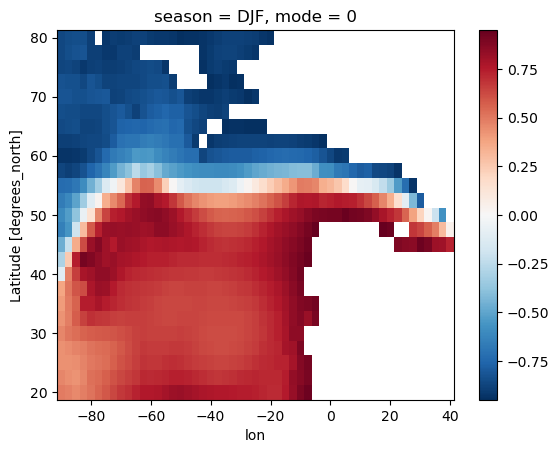

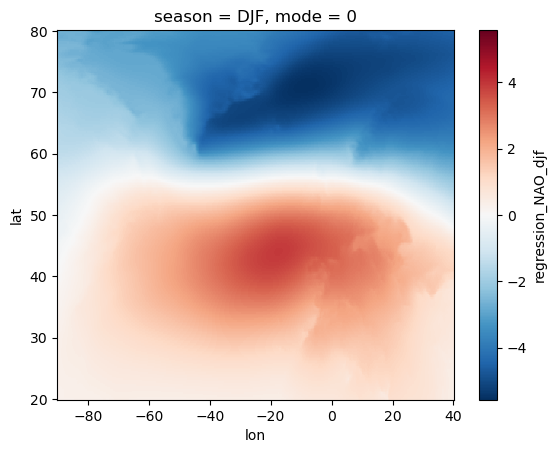

In [19]:
levels = np.arange(-1,1.1,0.1)
anomaly.plot(cmap='RdBu_r', center=0, levels=levels)
plt.show()

masked_anomaly = anomaly.where((anomaly >= -0.95) & (anomaly <= 0.95))
masked_anomaly.plot(cmap='RdBu_r', center=0)
plt.show()

era5['regression_NAO_djf'].plot()
plt.show()

In [17]:
print(nao_max.values, nao_min.values)

[[0.56791439 0.60858257 0.61224376 ... 0.23289277 0.21944399 0.14930515]
 [0.62711263 0.68163175 0.70665205 ... 0.31676318 0.27118044 0.20734971]
 [0.68966305 0.75292968 0.78937221 ... 0.38610039 0.30542142 0.24927125]
 ...
 [2.85064552 2.94634432 3.03937082 ... 3.95136972 3.93154323 3.91330864]
 [3.07067447 3.15916702 3.24008918 ... 4.13743588 4.1236007  4.11967454]
 [3.26693459 3.34439739 3.38985231 ... 4.14447291 4.14245106 4.13917829]] [[-0.53822436 -0.55082715 -0.51923157 ... -0.30256949 -0.24988285
  -0.15079328]
 [-0.58878998 -0.60846989 -0.59746611 ... -0.35030515 -0.28523155
  -0.21379406]
 [-0.61326903 -0.65098442 -0.66707111 ... -0.40429782 -0.32073424
  -0.26163225]
 ...
 [-2.76372668 -2.83563664 -2.91107109 ... -3.37158728 -3.30682252
  -3.2358397 ]
 [-2.95206187 -3.02019618 -3.08623096 ... -3.62803942 -3.54679911
  -3.46843141]
 [-3.09505177 -3.15381045 -3.19020877 ... -3.76107891 -3.71021688
  -3.65936584]]


In [20]:
#folderpath for the ensemble files
folder = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/historical/HadGEM3-GC31-LL/'

ens_files = [os.path.join(folder, filename) for filename in os.listdir(folder) if 'regression_map' in filename]

print(len(ens_files))

#opening each ensemble file and storing in one multi-dim array with new dimension ensemble as well as prev lat, lons.
ds = xr.open_mfdataset(ens_files, concat_dim='ensemble', combine='nested')

#extracting the nao regression data
EA = ds['regression_EA_djf']

print(EA.dims)
print(EA.shape)

#extracting the max and min from the ensemble spread
EA_max = EA.max(dim='ensemble')
EA_min = EA.min(dim='ensemble')

#now time to import era5
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/era5/era5_DJF_EA_regression_map_1940-2024.nc')

#This creates a regridder so I can put era5 onto the ensemble grid
regridder = xe.Regridder(era5, EA_max, method='bilinear', periodic=False)
era5_regrid = regridder(era5['regression_EA_djf'])

spread = (EA_max - EA_min)/2
midpoint = nao_min + spread
anomaly = (era5_regrid - midpoint)/spread

print(anomaly)

56
('ensemble', 'lat', 'lon')
(56, 25, 53)
<xarray.DataArray (lat: 25, lon: 53)> Size: 11kB
dask.array<truediv, shape=(25, 53), dtype=float64, chunksize=(25, 53), chunktype=numpy.ndarray>
Coordinates:
    season   <U3 12B 'DJF'
    mode     int64 8B 1
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0


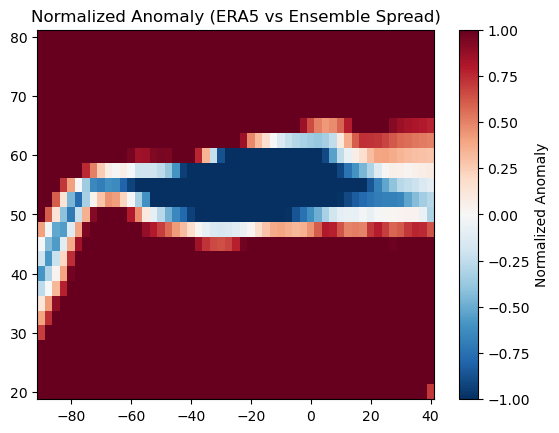

In [21]:
fig, ax = plt.subplots()

pcm = ax.pcolormesh(
    anomaly['lon'], anomaly['lat'], anomaly,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)

fig.colorbar(pcm, ax=ax, label='Normalized Anomaly')
ax.set_title('Normalized Anomaly (ERA5 vs Ensemble Spread)')
plt.show()

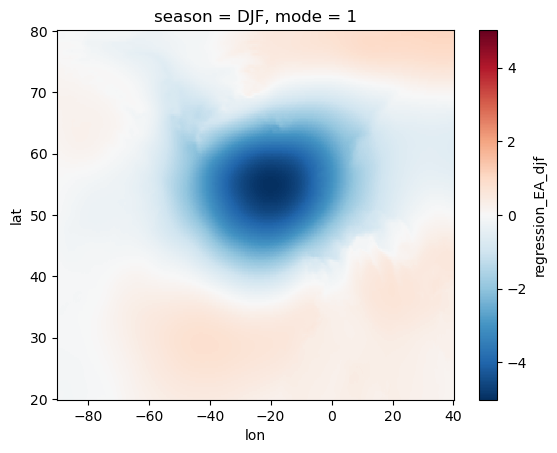

In [22]:
era5['regression_EA_djf'].plot()
plt.show()